In [1]:
from base_model import util
from base_model.trendNN_value import PricePredictionModel, Model
import numpy as np
import pandas as pd
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch.optim as optim
import random
import math
import os
random.seed(10)

# Hyperparameters

In [2]:
seq_len = 20
batch_size = 256

# Load AAPL Data

In [3]:
ticker = 'AAPL'
baseDataFolder = 'historical_1min'
trainStartDate = '20220101'
trainEndDate = '20220301'
testStartDate = '20220302'
testEndDate = '20220317'
testList, trainList, trainDFList, testDFlist = util.getTrainTestDataList(ticker, 
                          baseDataFolder,
                          trainStartDate=trainStartDate,
                          trainEndDate=trainEndDate,
                          testStartDate=testStartDate,
                          testEndDate=testEndDate,
                          printing=False)

trainDF = pd.concat(trainDFList,ignore_index=True)
testDF = pd.concat(testDFlist,ignore_index=True)
df = pd.concat([trainDF, testDF], ignore_index=True)
train_percent, val_percent = len(trainDF) / (len(trainDF) + len(testDF)) ,  len(testDF) / (len(trainDF) + len(testDF) )
train_index = int(len(df) * train_percent)
val_index = train_index 
test_index = int(train_index + len(testDF)* 0.5)

from CSC413 import DATA
df = pd.read_csv(f'{DATA}/{ticker}.csv')
train_percent, val_percent, test_percent = .8, .2, .1
train_index = int(len(df) * train_percent)
val_index = train_index 
test_index = int(train_index + len(df)*test_percent)

In [4]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,7.622500,7.660714,7.585000,7.643214,6.544687,493729600
1,2010-01-05,7.664286,7.699643,7.616071,7.656429,6.556002,601904800
2,2010-01-06,7.656429,7.686786,7.526786,7.534643,6.451721,552160000
3,2010-01-07,7.562500,7.571429,7.466071,7.520714,6.439793,477131200
4,2010-01-08,7.510714,7.571429,7.466429,7.570714,6.482608,447610800
...,...,...,...,...,...,...,...
3088,2022-04-08,171.779999,171.779999,169.199997,170.089996,170.089996,76515900
3089,2022-04-11,168.710007,169.029999,165.500000,165.750000,165.750000,72246700
3090,2022-04-12,168.020004,169.869995,166.639999,167.660004,167.660004,79265200
3091,2022-04-13,167.389999,171.039993,166.770004,170.399994,170.399994,70618900


In [5]:
df.iloc[val_index:test_index,:]

,Date,Open,High,Low,Close,Adj Close,Volume
2474,2019-10-31,61.810001,62.292500,59.314999,62.189999,61.018574,139162000
2475,2019-11-01,62.384998,63.982498,62.290001,63.955002,62.750332,151125200
2476,2019-11-04,64.332497,64.462502,63.845001,64.375000,63.162415,103272000
2477,2019-11-05,64.262497,64.547501,64.080002,64.282501,63.071667,79897600
2478,2019-11-06,64.192497,64.372498,63.842499,64.309998,63.098644,75864400
...,...,...,...,...,...,...,...
2778,2021-01-15,128.779999,130.220001,127.000000,127.139999,126.200226,111598500
2779,2021-01-19,127.779999,128.710007,126.940002,127.830002,126.885124,90757300
2780,2021-01-20,128.660004,132.490005,128.550003,132.029999,131.054077,104319500
2781,2021-01-21,133.800003,139.669998,133.589996,136.869995,135.858292,120150900


In [6]:
df.iloc[test_index:,:]

,Date,Open,High,Low,Close,Adj Close,Volume
2783,2021-01-25,143.070007,145.089996,136.539993,142.919998,141.863586,157611700
2784,2021-01-26,143.600006,144.300003,141.369995,143.160004,142.101807,98390600
2785,2021-01-27,143.429993,144.300003,140.410004,142.059998,141.009933,140843800
2786,2021-01-28,139.520004,141.990005,136.699997,137.089996,136.076675,142621100
2787,2021-01-29,135.830002,136.740005,130.210007,131.960007,130.984604,177523800
...,...,...,...,...,...,...,...
3088,2022-04-08,171.779999,171.779999,169.199997,170.089996,170.089996,76515900
3089,2022-04-11,168.710007,169.029999,165.500000,165.750000,165.750000,72246700
3090,2022-04-12,168.020004,169.869995,166.639999,167.660004,167.660004,79265200
3091,2022-04-13,167.389999,171.039993,166.770004,170.399994,170.399994,70618900


# Plot AAPL close prices

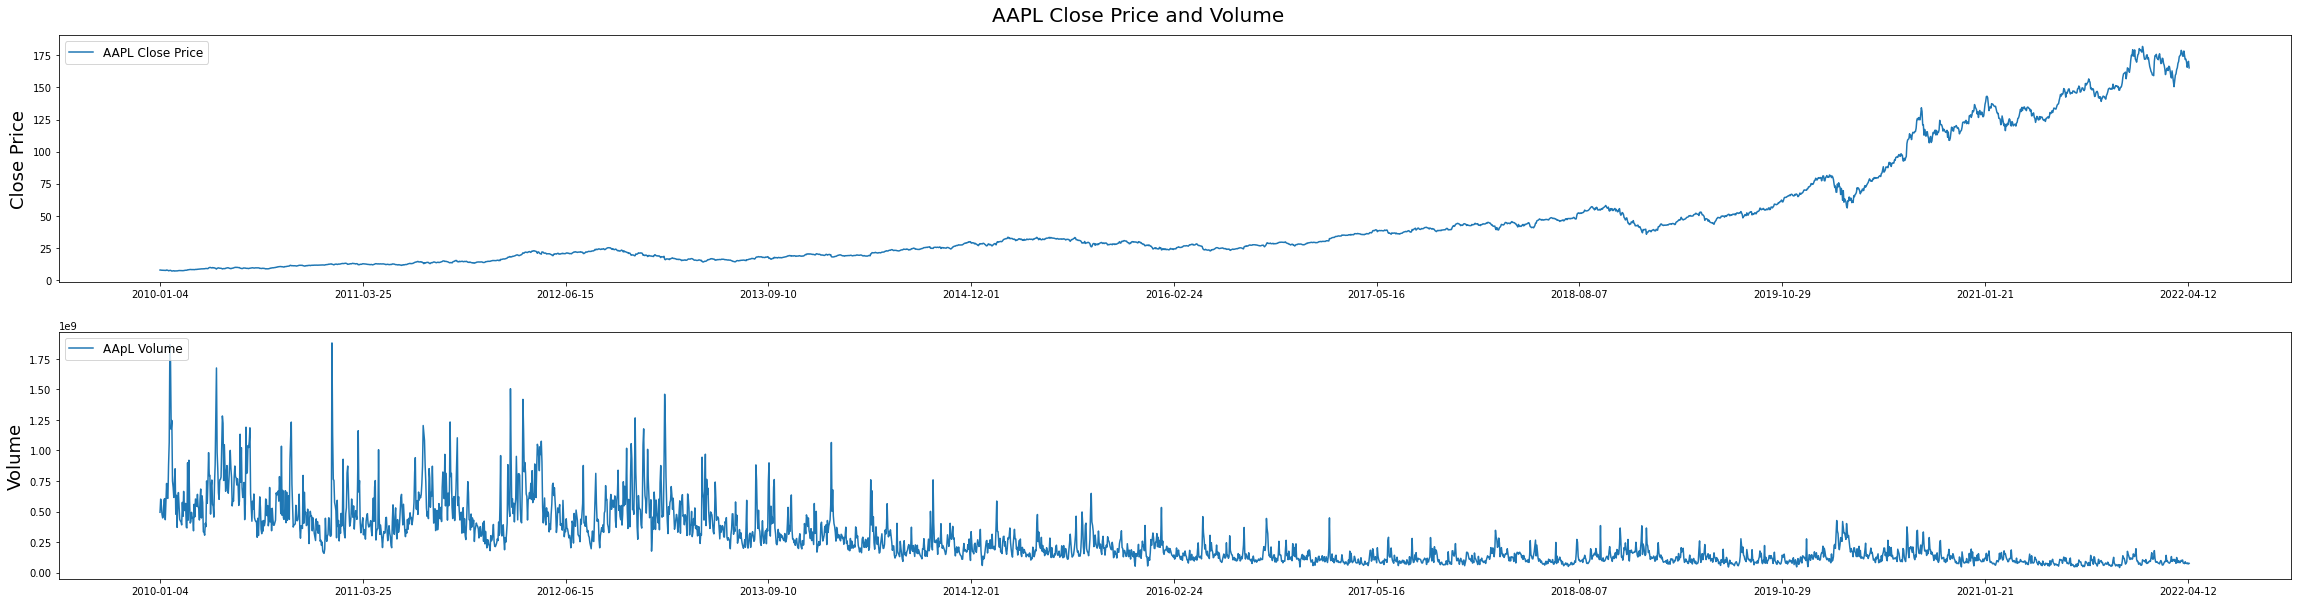

In [7]:
fig = plt.figure(figsize=(40, 10))
st = fig.suptitle("AAPL Close Price and Volume", fontsize=20)
st.set_y(0.92)

ax1 = fig.add_subplot(211)
ax1.plot(df['Close'], label='AAPL Close Price')
ax1.set_xticks(range(0, df.shape[0],  len(df)  // 10))
ax1.set_xticklabels(df['Date'].loc[:: len(df)  // 10]) # ax1.set_xticklabels(df['DateTime'].loc[:: len(df)  // 10])
ax1.set_ylabel('Close Price', fontsize=18)
ax1.legend(loc="upper left", fontsize=12)

ax2 = fig.add_subplot(212)
ax2.plot(df['Volume'], label='AApL Volume')
ax2.set_xticks(range(0, df.shape[0],  len(df)  // 10))
ax2.set_xticklabels(df['Date'].loc[:: len(df)  // 10]) # ax2.set_xticklabels(df['DateTime'].loc[:: len(df)  // 10])
ax2.set_ylabel('Volume', fontsize=18)
ax2.legend(loc="upper left", fontsize=12)

# Normalize data

In [8]:
scaler = MinMaxScaler()
normalizedDF = pd.DataFrame(data=df.loc[:,['Open','Close','High','Low', 'Volume']], columns=['Open','Close','High','Low', 'Volume'])
normalizedDF[['Open','Close','High','Low', 'Volume']] = scaler.fit_transform(df.loc[:,['Open','Close','High','Low', 'Volume']])
# normalizedDF = pd.DataFrame(data=df.loc[:,['Open','Close','High','Low']], columns=['Open','Close','High','Low'])
# normalizedDF[['Open','Close','High','Low']] = scaler.fit_transform(df.loc[:,['Open','Close','High','Low']])
normalizedDF

,Open,Close,High,Low,Volume
0,0.004279,0.004478,0.003755,0.004586,0.246049
1,0.004517,0.004553,0.003977,0.004767,0.304840
2,0.004472,0.003858,0.003904,0.004249,0.277805
3,0.003938,0.003778,0.003248,0.003896,0.237028
4,0.003643,0.004064,0.003248,0.003898,0.220984
...,...,...,...,...,...
3088,0.938268,0.931944,0.936569,0.942434,0.019302
3089,0.920801,0.907166,0.920939,0.920963,0.016982
3090,0.916875,0.918071,0.925713,0.927579,0.020796
3091,0.913291,0.933714,0.932363,0.928333,0.016097


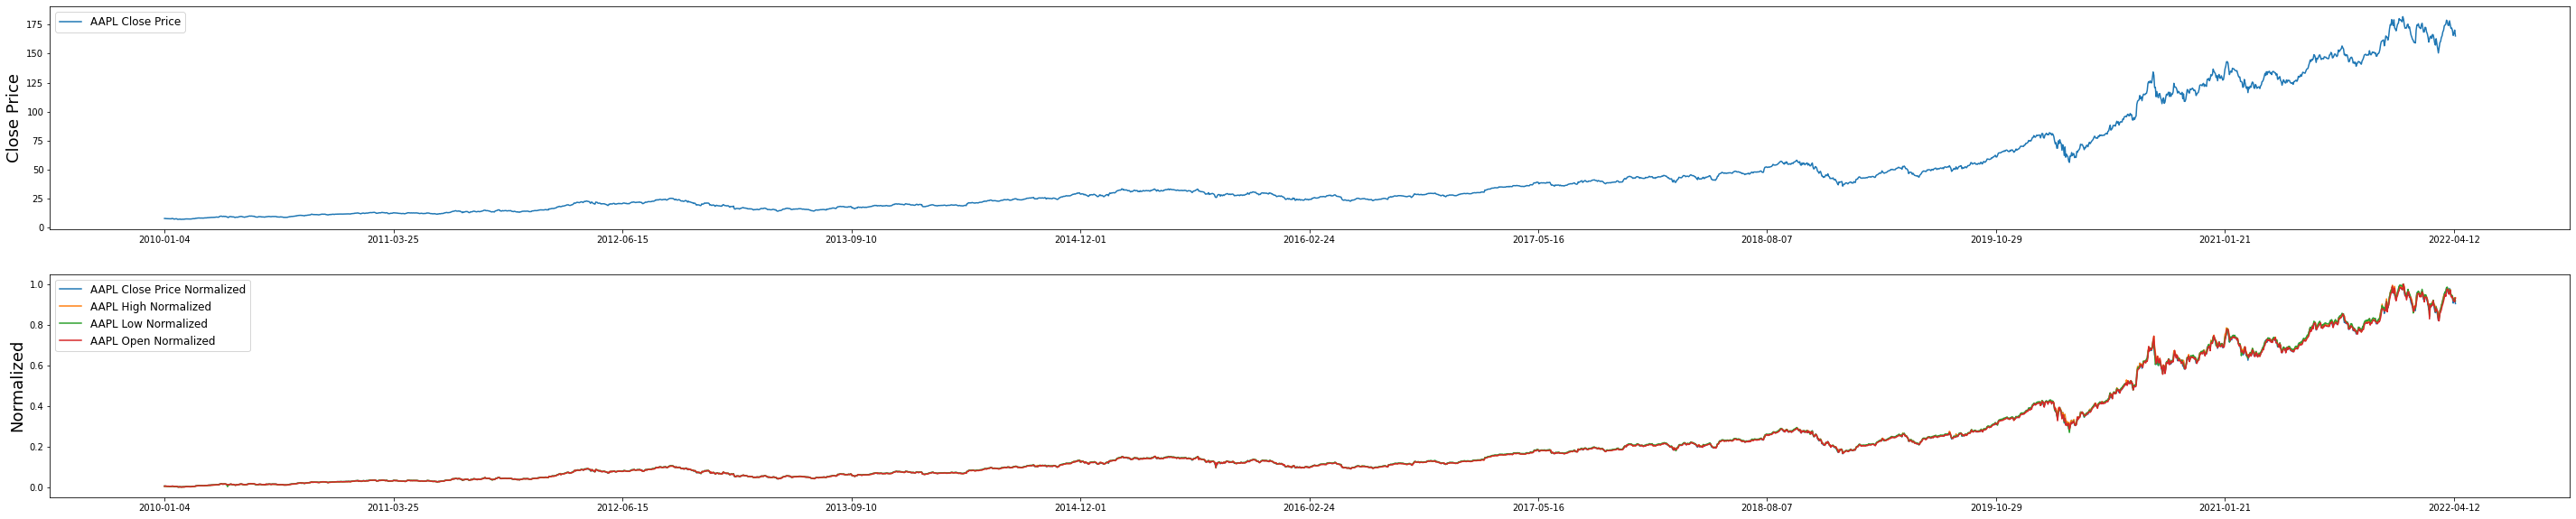

In [9]:
fig2 = plt.figure(figsize=(50, 10))
ax1 = fig2.add_subplot(211)
ax1.plot(df['Close'], label='AAPL Close Price')
ax1.set_xticks(range(0, df.shape[0],  len(df)  // 10))
ax1.set_xticklabels(df['Date'].loc[:: len(df)  // 10])
ax1.set_ylabel('Close Price', fontsize=18)
ax1.legend(loc="upper left", fontsize=12)

ax2 = fig2.add_subplot(212)
ax2.plot(normalizedDF['Close'], label='AAPL Close Price Normalized')
ax2.plot(normalizedDF['High'], label='AAPL High Normalized')
ax2.plot(normalizedDF['Low'], label='AAPL Low Normalized')
ax2.plot(normalizedDF['Open'], label='AAPL Open Normalized')
ax2.set_xticks(range(0, df.shape[0],  len(df)  // 10))
ax2.set_xticklabels(df['Date'].loc[:: len(df)  // 10])
ax2.set_ylabel('Normalized', fontsize=18)
ax2.legend(loc="upper left", fontsize=12)


# Create chunks of training, validation and test data

In [12]:
train_data = normalizedDF.iloc[:train_index,:].to_numpy()
val_data = normalizedDF.iloc[val_index:test_index,:].to_numpy()
test_data = normalizedDF.iloc[test_index:,:].to_numpy()

# Training data
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
  X_train.append(train_data[i-seq_len:i]) # Chunks of training data with a length of 128 df-rows
  y_train.append(train_data[:, 1][i]) #Value of 2nd column (Close Price) of df-row 128+1
X_train, y_train = np.array(X_train), np.array(y_train)

###############################################################################

# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
    X_val.append(val_data[i-seq_len:i])
    y_val.append(val_data[:, 1][i])
X_val, y_val = np.array(X_val), np.array(y_val)

###############################################################################

# Test data
X_test, y_test = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i-seq_len:i])
    y_test.append(test_data[:, 1][i])    
X_test, y_test = np.array(X_test), np.array(y_test)

print('Training set shape', X_train.shape, y_train.shape)
print('Validation set shape', X_val.shape, y_val.shape)

Training set shape (2454, 20, 5) (2454,)
Validation set shape (289, 20, 5) (289,)


# LSTM Base Model

Model total parameters: 41770
100 epoch. Train loss is 0.004880484659224749
100 epoch. Validation loss is 0.06699169427156448
200 epoch. Train loss is 0.003767695976421237
200 epoch. Validation loss is 0.09028422832489014
300 epoch. Train loss is 0.008715319447219372
300 epoch. Validation loss is 0.1677267998456955
400 epoch. Train loss is 0.0054681613110005856
400 epoch. Validation loss is 0.13588106632232666
500 epoch. Train loss is 0.003002977930009365
500 epoch. Validation loss is 0.07167396694421768
600 epoch. Train loss is 0.005759295541793108
600 epoch. Validation loss is 0.04117382690310478
700 epoch. Train loss is 0.0023276032879948616
700 epoch. Validation loss is 0.06538215279579163
800 epoch. Train loss is 0.0036869351752102375
800 epoch. Validation loss is 0.09974497556686401
900 epoch. Train loss is 0.0043447124771773815
900 epoch. Validation loss is 0.09540048986673355
1000 epoch. Train loss is 0.0012887823395431042
1000 epoch. Validation loss is 0.05038154497742653
1100

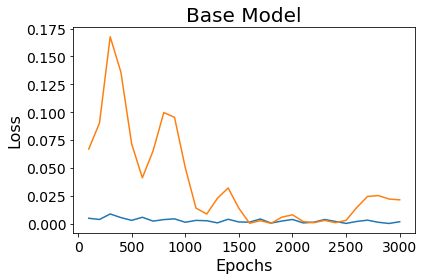

In [14]:
args = util.AttrDict()
args_dict = {
    "cuda": True,
    "learning_rate": 0.0001,
    "batch_size": batch_size,
    "device": 'cuda:1',
    "seq_len": seq_len,
    "ff_dims": 72,
    "dropout": 0.2,
    "weight_decay": 0.001,
    "total_epoch": 3000,
    "validation_window": 100,
    "nLayers": 1,
    "miniBatch": False,
    "save_window": 10,
    "training_name": 'baseModelMostRecent',
}
args.update(args_dict)
device = torch.device(args.device)
# model = Model(train_data.shape[1],1, args=args).to(device)
model = PricePredictionModel(train_data.shape[1],1, args=args).to(device)


def learn(model,args):
    
    model_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)  
    print(f'Model total parameters: {model_total_params}')
    # optimizer = optim.Adam(model.parameters(), lr = args.learning_rate, betas=[0.9, 0.999], weight_decay=args.weight_decay)
    optimizer = optim.Adam(model.parameters(), lr = args.learning_rate)
    criterion = nn.MSELoss()
    trainFlag = True
    
    import random
    random.seed(10)
    
    optStep = 0
    running_loss = 0
    epoch = 1
    validation_losses = []
    train_losses = []
    Y_val = torch.FloatTensor(y_val).to(device)
    
    
    # save folders
    base_log_folder = './log'
    save_folder = f'{base_log_folder}/{args.training_name}-lr{args.learning_rate}-{args.ff_dims}-{args.nLayers}'
    if not os.path.isdir(base_log_folder):
        os.mkdir(base_log_folder)
    if not os.path.isdir(save_folder):
        os.mkdir(save_folder)
    else:
        count = 2
        save_folder = f'{save_folder}-{count}'
        while os.path.isdir(save_folder):
            count+=1
        os.mkdir(save_folder)
    
    for epoch in range(args.total_epoch):
        cursor = 0
        epoch_loss = []
        if args.miniBatch:
            for i in range(math.ceil(X_train.shape[0]/args.batch_size)):
                cursor = i * args.batch_size
                end_cursor = (i + 1) * args.batch_size 
                # samples = random.sample(range(0, X_train.shape[0]), batch_size)

                # x = X_train[:i, :, :]
                # y = y_train[samples]

                x = X_train[cursor: end_cursor, :, :] 
                y = y_train[cursor: end_cursor]

                y = torch.FloatTensor(y).to(device)
                predictions = model(x)

                loss = criterion(predictions, y)

                loss.backward()
                optimizer.step()

                epoch_loss.append(loss.item())
            running_loss = np.average(epoch_loss)
            epoch += 1
        else:
            y = torch.FloatTensor(y_train).to(device)
            predictions = model(X_train)

            loss = criterion(predictions, y)

            loss.backward()
            optimizer.step()

            epoch_loss.append(loss.item())
            running_loss = np.average(epoch_loss)
            epoch += 1
        
        if epoch % args.validation_window == 0:
            # validation
            predictions = model(X_val)
            loss = criterion(predictions, Y_val).squeeze().item()
            if epoch % args.save_window == 0:
                torch.save(model, f'{save_folder}/policy_{epoch}.para')
                
            print(str(epoch) + ' epoch. Train loss is ' + str(running_loss))
            util.printOkBlue(str(epoch) + ' epoch. Validation loss is ' + str(loss))
            train_losses.append(running_loss)
            validation_losses.append(loss)
    
    print(f'training done')
    return train_losses, validation_losses


t_loss, v_loss = learn(model, args)

def plot_loss(t_loss, v_loss, title):
    import matplotlib.pyplot as plt
    import matplotlib.ticker as ticker
    plt.figure()
    plt.plot(range(args.validation_window, args.total_epoch + 1, args.validation_window), t_loss)
    plt.plot(range(args.validation_window, args.total_epoch + 1, args.validation_window), v_loss)
    plt.title(title, fontsize=20)
    plt.xlabel("Epochs", fontsize=16)
    plt.ylabel("Loss", fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout()
plot_loss(t_loss, v_loss, 'Base Model')   

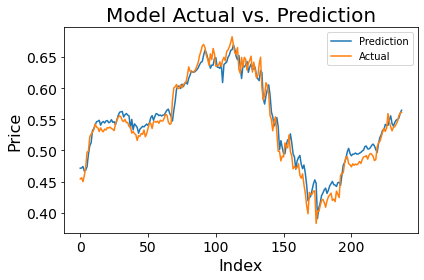

In [39]:
# model = torch.load('/home/guest/CSC413/CSC413GroupProject/log/baseModel-lr0.0001-64-1-2/policy_1130.para') # best model
model = torch.load('/home/guest/CSC413/CSC413GroupProject/log/baseModelMostRecent-lr0.0001-72-1/policy_1600.para') 
predictions = model(X_val).squeeze().cpu().detach().numpy()
plt.figure()
plt.plot(range(len(predictions)), predictions, label='Prediction')
plt.plot(range(len(y_val)), y_val, label='Actual')
plt.title('Model Actual vs. Prediction', fontsize=20)
plt.xlabel("Index", fontsize=16)
plt.ylabel("Price", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend()
plt.tight_layout()